# import libraries


In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import time
import csv
import pickle
import re

# Import Data

In [9]:
main_path = os.getcwd().replace('AIModels','')+'dataset/localization/'
data = []
state=True
for i in ['5dataset_train.pkl']:#sorted(os.listdir(main_path), key=lambda x: int(re.match(r'(\d+)', x).group())):#
    if 'train' in i:
        if state:
            test_path = main_path+i.replace('train', 'test')
            X_test = pd.read_pickle(test_path)
            X_test = X_test.loc[X_test[0]>0,:]
            num_samples = len(X_test)
            random_indices = np.random.choice(num_samples, size=int(0.05 * num_samples), replace=False)
            X_test = X_test.loc[random_indices]
            y_test = X_test.loc[:,0]-1
            X_test = X_test.drop(columns=0)
            state = False

        print(i)
        X_train = pd.read_pickle(main_path+i)
        
        X_train = X_train.loc[X_train[0]>0,:]
        
        y_train = X_train.loc[:,0]-1
        
        X_train = X_train.drop(columns=0)

        estimators = [#DecisionTreeClassifier(),
                        RandomForestClassifier(n_estimators=30, random_state=0, n_jobs=-1), 
                        #make_pipeline(StandardScaler(), SVC(C=0.7)),
                        #SGDClassifier(loss="log", penalty="l1", max_iter=25),
                        #GaussianNB(),
                        #KNeighborsClassifier(n_neighbors=28),
                        #GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=0),
                        #MLPClassifier(max_iter= 100),
                        #AdaBoostClassifier(n_estimators=100, random_state=0),
                        #QuadraticDiscriminantAnalysis()
                        ]
        #main loop
        for i in range(0,len(estimators)): 
            ##make_pipeline
            pipe = make_pipeline(estimators[i])
            print(pipe.steps[0])
            
            ##training
            start_time = time.time()
            pipe.fit(X=X_test, y=y_test)
            end_time = time.time()
            training_time = (end_time-start_time)
            print('trainig time (sec): ', training_time)
            
            ##predition on test data
            start_time = time.time()
            y_pred = pipe.predict(X_test)
            end_time = time.time()
            prediction_time = (end_time-start_time)*10e3/y_test.shape[0]
            print('prediction time (ms): ', prediction_time)

            ##metrics
            balanced_accuracy_score = metrics.balanced_accuracy_score(y_test, y_pred)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            percision = metrics.precision_score(y_test, y_pred, average=None)
            f1_score = metrics.f1_score(y_test, y_pred, average=None)
            recall= metrics.recall_score(y_test, y_pred, average=None)

            print('Balanced accuracy on source domain data: ', balanced_accuracy_score)
            
            ##write to csv
            data.append([pipe.steps[0][0], training_time, prediction_time, balanced_accuracy_score, accuracy, percision, f1_score, recall])
            #csv_writer.writerow(data)
            print(metrics.confusion_matrix(y_pred=y_pred, y_true=y_test))

        #close the csv file
        #file.close()

5dataset_train.pkl
('randomforestclassifier', RandomForestClassifier(n_estimators=30, n_jobs=-1, random_state=0))
trainig time (sec):  0.40821361541748047
prediction time (ms):  2.4423334333631725
Balanced accuracy on source domain data:  0.9989010989010989
[[ 22   0   0   0   0   0   0]
 [  0  57   0   0   0   0   0]
 [  0   0  46   0   0   0   0]
 [  0   0   0  81   0   0   0]
 [  0   0   0   0 122   0   0]
 [  0   0   0   0   1 129   0]
 [  0   0   0   0   0   0  82]]


In [10]:
from sklearn.pipeline import Pipeline
import joblib

# Assuming 'pipe' is your trained sklearn pipeline
joblib.dump(pipe, 'model_pipeline.pkl')

['model_pipeline.pkl']

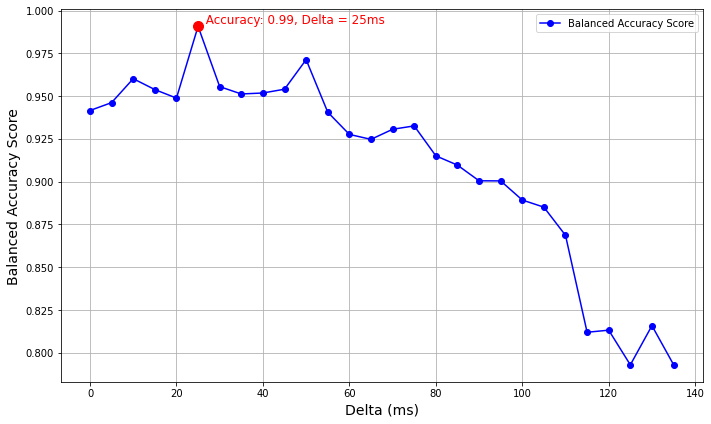

In [41]:
import matplotlib.pyplot as plt

# Assuming data is a list of lists where balanced_accuracy_score is the 3rd element in each row
balanced_accuracy_scores = [row[3] for row in data]

# Get the row positions (indices) for the x-axis and multiply each by 5
row_positions = [(i) * 5 for i in range(len(data))]

# Find the maximum value and its position
max_value = max(balanced_accuracy_scores)
max_index = balanced_accuracy_scores.index(max_value)
max_row_position = row_positions[max_index]

# Plot the line chart
plt.figure(figsize=(10, 6))  # High-quality figure size
plt.plot(row_positions, balanced_accuracy_scores, label='Balanced Accuracy Score', color='blue', marker='o')

# Highlight the max value
plt.scatter(max_row_position, max_value, color='red', s=100, zorder=5)  # Highlight max point with red
plt.text(max_row_position, max_value, f'  Accuracy: {max_value:.2f}, Delta = {max_row_position}ms', fontsize=12, ha='left', va='bottom', color='red')

# Labeling the chart
plt.xlabel('Delta (ms)', fontsize=14)
plt.ylabel('Balanced Accuracy Score', fontsize=14)
plt.legend()

# Improve layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


# test on target robot


In [22]:
main_path = os.getcwd().replace('AIModels','')

data_path = main_path + 'dataset/test_dataset_target_robot/dataset_test.pkl'

X = pd.read_pickle(data_path)
if 0 in X[0].unique():
    X = X.loc[X[0]>0,:].reset_index()
    y = X.loc[:,0]-1
    print('yyes')
else:
    y = X.loc[:,0]



X = X.drop(columns=[0])

##predition on test data
start_time = time.time()
y_p = pipe.predict(X)
end_time = time.time()
prediction_time = (end_time-start_time)*10e3/y.shape[0]
print('prediction time (ms): ', prediction_time)

##metrics
balanced_accuracy_score = metrics.balanced_accuracy_score(y, y_p)
accuracy = metrics.accuracy_score(y, y_p)
percision = metrics.precision_score(y, y_p, average=None)
f1_score = metrics.f1_score(y, y_p, average=None)
recall= metrics.recall_score(y, y_p, average=None)

print('Balanced accuracy on source domain data: ', balanced_accuracy_score)
print(metrics.confusion_matrix(y_true=y, y_pred=y_p))

yyes
prediction time (ms):  2.808757082245054


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Balanced accuracy on source domain data:  0.014705882352941176
[[  0 300 205]
 [  0  10 330]
 [  0   0   0]]


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# test with LSTM model

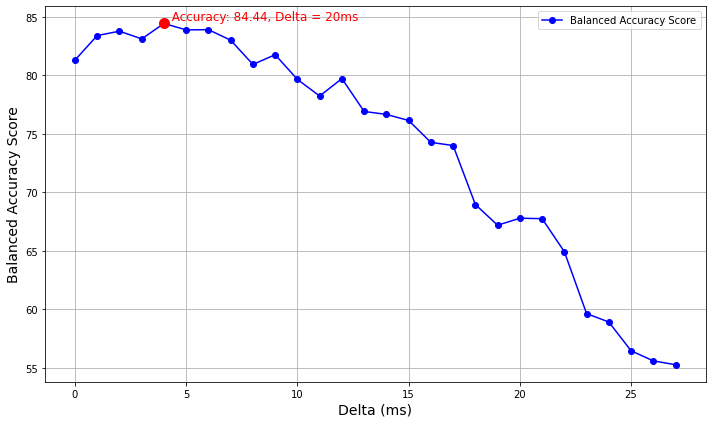

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('AI_result/dataset_test_result.csv')

# Extract the balanced accuracy scores
balanced_accuracy_scores = df.test_on_0_dataset

# Find the maximum value and its corresponding position
max_value = balanced_accuracy_scores.max()
max_row_position = balanced_accuracy_scores.idxmax()

# Plot the line chart
plt.figure(figsize=(10, 6))  # High-quality figure size
plt.plot(balanced_accuracy_scores.index, balanced_accuracy_scores, label='Balanced Accuracy Score', color='blue', marker='o')

# Highlight the max value
plt.scatter(max_row_position, max_value, color='red', s=100, zorder=5)  # Highlight max point with red
plt.text(max_row_position, max_value, f'  Accuracy: {max_value:.2f}, Delta = {max_row_position*5}ms', fontsize=12, ha='left', va='bottom', color='red')

# Labeling the chart
plt.xlabel('Delta (ms)', fontsize=14)
plt.ylabel('Balanced Accuracy Score', fontsize=14)
plt.legend()

# Improve layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


# test on real-time robot data

In [3]:
import sys
import os

#bash robotAPI/frankapy/bash_scripts/start_control_pc.sh -i localhost

# Source ROS setup.bash
os.system('source /opt/ros/noetic/setup.bash')

# Source your Franka workspace
os.system('source /home/rzma/robotsAPI/franka-interface/catkin_ws/devel/setup.bash')
os.system('source /home/rzma/robotsAPI/frankapy/catkin_ws/devel/setup.bash')

# Add ROS Python libraries to Python path
sys.path.append('/opt/ros/noetic/lib/python3/dist-packages')

# Manually add your workspace to ROS_PACKAGE_PATH
sys.path.append('/home/rzma/robotsAPI/franka-interface/catkin_ws/devel/lib/python3/dist-packages')

import rospy
from franka_interface_msgs.msg import RobotState


# Define global variables
global window
window = np.zeros((28, 7))
features_num = 7
num_features_lstm = 1
dof = 7

def contact_detection(data):
    global window
    e_q = np.array(data.q_d) - np.array(data.q)
    
    new_row = e_q.reshape((1, features_num))
    window = np.append(window[1:,:], new_row, axis=0)

    stackedWindow = np.hstack(window).reshape(1, 196)
    
    # Assuming the 'pipe' object is properly defined
    model_out = pipe.predict(stackedWindow)
    print('model_out = %s', model_out)

if not rospy.core.is_initialized():
    rospy.init_node('contact_detection_node', anonymous=True)
    print('Node initialized')
else:
    print('Node was already initialized')


# Set up the subscriber
rospy.Subscriber(name="/robot_state_publisher_node_1/robot_state", data_class=RobotState, callback=contact_detection)
print('Subscriber initialized')  # Print to confirm the subscriber is active

# Keep the node alive and spinning
rospy.spin()


Node initialized
Subscriber initialized
model_out = %s [1.]
model_out = %s [1.]
model_out = %s [0.]
model_out = %s [4.]
model_out = %s [4.]
model_out = %s [4.]
model_out = %s [4.]
model_out = %s [4.]
model_out = %s [4.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]
model_out = %s [5.]


In [13]:
pipe.predict(np.hstack(window).reshape(1, 196))

array([5.])

In [5]:
import sys
import signal
import os

#bash robotAPI/frankapy/bash_scripts/start_control_pc.sh -i localhost

# Source ROS setup.bash
os.system('source /opt/ros/noetic/setup.bash')

# Source your Franka workspace
os.system('source /home/rzma/robotsAPI/franka-interface/catkin_ws/devel/setup.bash')
os.system('source /home/rzma/robotsAPI/frankapy/catkin_ws/devel/setup.bash')

# Add ROS Python libraries to Python path
sys.path.append('/opt/ros/noetic/lib/python3/dist-packages')

# Manually add your workspace to ROS_PACKAGE_PATH
sys.path.append('/home/rzma/robotsAPI/franka-interface/catkin_ws/devel/lib/python3/dist-packages')

import rospy


# Function to handle the shutdown signal
def shutdown_handler(signal, frame):
    print('Shutting down node...')
    rospy.signal_shutdown('Node shutting down due to Ctrl+C')
    sys.exit(0)

# Set up the Ctrl+C (SIGINT) handler
signal.signal(signal.SIGINT, shutdown_handler)

# Initialize the node
if not rospy.core.is_initialized():
    rospy.init_node('contact_detection_node', anonymous=True)
    print('Node initialized')

# Your main ROS logic
try:
    # Replace this with your ROS logic (subscriber, spin, etc.)
    rospy.spin()

except KeyboardInterrupt:
    # This will catch manual Ctrl+C as a fallback
    print('Caught Ctrl+C, shutting down node...')
    rospy.signal_shutdown('Manual shutdown due to KeyboardInterrupt')
    sys.exit(0)


In [8]:
from sklearn.pipeline import Pipeline
import joblib

# Assuming 'pipe' is your trained sklearn pipeline
joblib.dump(pipe, 'model_pipeline.pkl')


['model_pipeline.pkl']